In [24]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu
from importlib import reload
reload(dp)
reload(iu)

import os
import matplotlib.pyplot as plt

In [25]:
dp.test()
iu.test()

Testing data processing.
Testing improved unet.


In [26]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = dataset_path + "keras_png_slices_seg_test/"
seg_train_path = dataset_path + "keras_png_slices_seg_train/"
seg_val_path = dataset_path + "keras_png_slices_seg_validate/"
test_path = dataset_path + "keras_png_slices_test/"
train_path = dataset_path + "keras_png_slices_train/"
val_path = dataset_path + "keras_png_slices_validate/"

In [27]:
# Load images
seg_test = dp.load_image(seg_test_path)
seg_train = dp.load_image(seg_train_path)
seg_val = dp.load_image(seg_val_path)
test = dp.load_image(test_path)
train = dp.load_image(train_path)
val = dp.load_image(val_path)

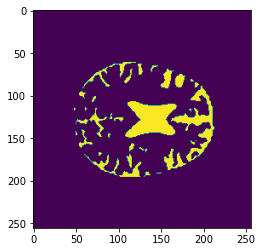

In [46]:
plt.imshow(seg_train[0])

In [41]:
# One hot encode labels
seg_test = dp.one_hot_encode(seg_test)
seg_train = dp.one_hot_encode(seg_train)
seg_val = dp.one_hot_encode(seg_val)

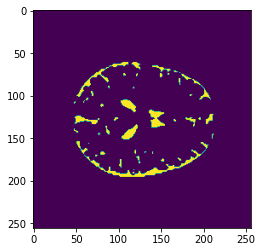

In [43]:
plt.imshow(seg_train[0][:,:,2])

In [59]:
reload(iu)
model = iu.unet()

Tensorflow version: 2.1.0
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 256, 256, 16) 592         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_52[0][0]                  
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 256, 256, 16) 0           conv2d_53[0][0]                  
__________________________________________________________________